# ChordGAN

ChordGAN importing the models from a py file

In [1]:
import reverse_pianoroll
import convert

import numpy as np
import matplotlib.pyplot as plt
import glob
from functools import reduce

import tensorflow as tf
from tensorflow import keras

from src.preprocess import load_data

%load_ext lab_black
%load_ext tensorboard

# python script, in github repo
print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Numpy version:", np.__version__)

TF version: 2.6.0
Keras version: 2.6.0
Numpy version: 1.21.2


Use the following to avoid GPU errors (if needed)

In [2]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

## Setup helper functions

## Load data

In [3]:
fpath = "../data/chordGan"
genre = ""

dataset = load_data(fpath, genre="classical")

C:\Users\gamin\anaconda3\envs\chordgan\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Creating TF dataset from the loaded songs
Creating TF dataset from the loaded songs
Complete.


In [4]:
sample_songs = []
sample_chromas = []

for s, c in dataset.take(10):
    sample_songs.append(s.numpy())
    sample_chromas.append(c.numpy())

Let's peek at the chromas

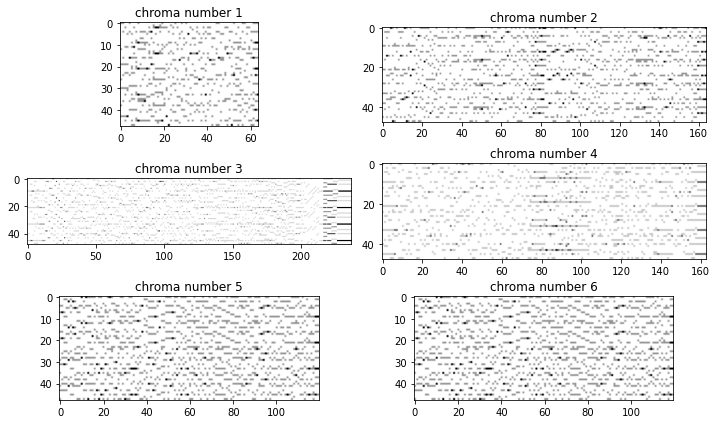

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, (chroma, ax) in enumerate(zip(sample_chromas[:10], axes.flatten())):
    ax.set_title(f"chroma number {i+1}")
    ax.imshow(chroma[:48].T, cmap="Greys")
plt.tight_layout()
plt.show()

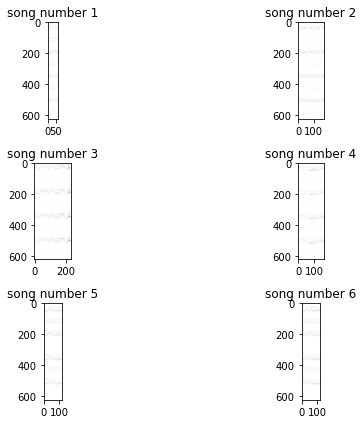

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, (song, ax) in enumerate(zip(sample_songs[:10], axes.flatten())):
    ax.set_title(f"song number {i+1}")
    ax.imshow(song[:128].T, cmap="Greys")
plt.tight_layout()
plt.show()

TODO: Are the reshaped chromas/songs correct?

## Setup GAN model

Note:

The discriminator has both the song timeseries and the chromagram as inputs, hence the two-dimensional inputs!

In [7]:
from src.model import ChordGAN

cgan = ChordGAN()
cgan.compile(tf.keras.optimizers.Adam(lr=1e-5), tf.keras.optimizers.Adam(lr=1e-4))

C:\Users\gamin\anaconda3\envs\chordgan\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test the generator

(1, 64, 624)


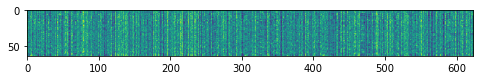

In [8]:
sample_chroma = sample_chromas[0]
sample_out = cgan.generator(sample_chroma)

print(sample_out.shape)
plt.figure(figsize=(8, 6))
plt.imshow(sample_out[0])
plt.show()

Test the discriminator

In [9]:
sample_song = sample_songs[0]
sample_logits, sample_probas = cgan.discriminator((sample_song, sample_chroma))
print(
    f"Probability this is a true song, not a generated song: {tf.reduce_mean(sample_probas).numpy():.2%} "
)

Probability this is a true song, not a generated song: 59.08% 


# Training

We define a training step that will propagate the gradients for both generator and discriminator

In [10]:
cgan.fit(dataset, batch_size=10, epochs=500)

Epoch 1/500
11/11 [==============================] - 1s 13ms/step - d_loss: 1.5778 - g_loss: 27.7126
Epoch 2/500
11/11 [==============================] - 0s 12ms/step - d_loss: 1.3065 - g_loss: 27.0745
Epoch 3/500
11/11 [==============================] - 0s 12ms/step - d_loss: 1.1109 - g_loss: 26.4711
Epoch 4/500
11/11 [==============================] - 0s 11ms/step - d_loss: 0.9772 - g_loss: 25.9061
Epoch 5/500
11/11 [==============================] - 0s 12ms/step - d_loss: 0.8808 - g_loss: 25.3523
Epoch 6/500
11/11 [==============================] - 0s 12ms/step - d_loss: 0.8264 - g_loss: 24.6901
Epoch 7/500
11/11 [==============================] - 0s 11ms/step - d_loss: 0.7835 - g_loss: 24.0855
Epoch 8/500
11/11 [==============================] - 0s 11ms/step - d_loss: 0.7510 - g_loss: 23.4437
Epoch 9/500
11/11 [==============================] - 0s 12ms/step - d_loss: 0.7200 - g_loss: 22.7973
Epoch 10/500
11/11 [==============================] - 0s 12ms/step - d_loss: 0.7063 - g_los

We can access the losses via `history.history`

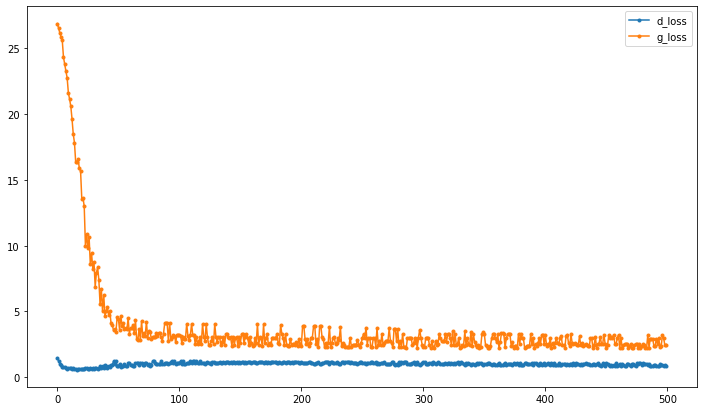

In [11]:
hist = cgan.history.history

plt.figure(figsize=(12, 7))
plt.plot(range(len(hist["d_loss"])), hist["d_loss"], ".-", label="d_loss")
plt.plot(range(len(hist["g_loss"])), hist["g_loss"], ".-", label="g_loss")
plt.legend()
plt.show()

#### TODO:
Now that i'm able to train the model, I need to implement the `call` method, that will convert the songs, if the model is trained.

In [14]:
cgan.save_weights("trained_models/weights/classical_500e")

In [16]:
new_cgan = ChordGAN()
new_cgan.load_weights("trained_models/weights/classical_500e")

In [17]:
out = new_cgan(sample_chroma)
out

Naturally it doesn't make sense to look at this as an image but it at least shows the result is close enough

# Style Transfer

In [ ]:
new_ds = load_data("../data/chordGan", "pop")

Creating TF dataset from the loaded songs
Creating TF dataset from the loaded songs
Complete.


In [ ]:
cgan(sample_chroma)

In [ ]:
new_cgan(sample_chroma)